In [ ]:
# Copyright Elasticsearch B.V. and/or licensed to Elasticsearch B.V. under one
# or more contributor license agreements. Licensed under the Elastic License;
# you may not use this file except in compliance with the Elastic License.

#### Goal

Sample datapoint that will resample the distribution on leaves of the original training set forest.

#### Idea

Input: $k$ sample size, $b$ number of batches, $D$ training dataset of size $n$ \
Output: $D_s$ sample dataset of size $k$
1. Take a batch of data points of size $n/b$
2. Select a tree $t$ from the forest at random
3. Compute uniform variates $v_i := -\ln(random())/w_i$ and select $k/b$ smalles elements


In [830]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import json
import string
import random

import pandas as pd
import numpy as np
import scipy.stats
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns

from utils.misc import *
from utils.trees import Forest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_name = 'ccpp'
D = pd.read_csv('datasets/{}.csv'.format(dataset_name))
D.drop_duplicates(inplace=True)

In [4]:
job1 = train(dataset_name, D)
job1.wait_to_complete()

stderr,output
"/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpj1iaccj4 --config /tmp/tmp2d1idrpm --output /tmp/tmpxex0hstw --persist /tmp/tmpdlfgnnoj (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 4…21⚑ 3] 10:51 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpj1iaccj4 --config /tmp/tmp2d1idrpm --output /tmp/tmpxex0hstw --persist /tmp/tmpdlfgnnoj 2021-03-11 09:51:19,289731 UTC [11373] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV 2021-03-11 09:51:19,290330 UTC [11373] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj 2021-03-11 09:51:19,290384 UTC [11373] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available 2021-03-11 09:51:19,293406 UTC [11373] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed 2021-03-11 09:51:19,327648 UTC [11373] DEBUG CDataFrameAnalyzer.cc@104 Received 9527 rows 2021-03-11 09:51:53,824478 UTC [11373] INFO CBoostedTreeImpl.cc@237 Exiting hyperparameter optimisation loop early 2021-03-11 09:51:56,688059 UTC [11373] INFO Main.cc@241 [{""name"":""E_DFTPMEstimatedPeakMemoryUsage"",""description"":""The upfront estimate of the peak memory training the predictive model would use"",""value"":27586018} ,{""name"":""E_DFTPMPeakMemoryUsage"",""description"":""The peak memory training the predictive model used"",""value"":13596976} ,{""name"":""E_DFTPMTimeToTrain"",""description"":""The time it took to train the predictive model"",""value"":36268} ,{""name"":""E_DFTPMTrainedForestNumberTrees"",""description"":""The total number of trees in the trained forest"",""value"":162} ] 2021-03-11 09:51:56,688093 UTC [11373] DEBUG Main.cc@246 ML data frame analyzer exiting (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 4…21⚑ 3] 10:51 $",",{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":443.2151489257812 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":465.7640686035156 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":467.7299194335937 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":459.4170227050781 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":469.1076049804687 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":429.8967895507812 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":438.5669555664062 ,{""row_results"":{""checksum"":0,""results"":{""ml"":{""PE_prediction"":452.3844299316406 ,{""model_metadata"":{""total_feature_importance"":[],""hyperparameters"":[{""name"":""do ]"


Job succeeded


True

In [6]:
definition = job1.get_model_definition()

In [7]:
trained_models = definition['trained_model']['ensemble']['trained_models']

In [211]:
forest = Forest(trained_models)

In [835]:
sample = batch_sampling(forest, D, 0.25, 'tree-guided')

/home/valeriy/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/utils/misc.py:422: RuntimeWarning: invalid value encountered in log
  S.next()


### Test that I preserve the distribution over leaves

#### First simply eye-balling

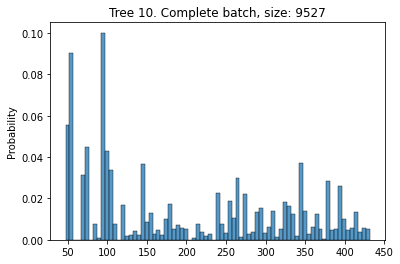

In [837]:
test_tree_index = 10
leaf_ids = []
for row in D.iterrows():
    leaf_ids.append(forest.trees[test_tree_index].get_leaf_id(row[1].to_dict()))
ax = sns.histplot(leaf_ids, binwidth=5,  stat='probability')
_ = ax.set_title("Tree {}. Complete batch, size: {}".format(test_tree_index, D.shape[0]))

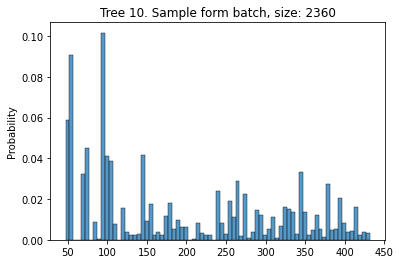

In [838]:
leaf_ids = []
for row in sample.iterrows():
    leaf_ids.append(forest.trees[test_tree_index].get_leaf_id(row[1].to_dict()))
ax = sns.histplot(leaf_ids,binwidth=5,  stat='probability')
_ = ax.set_title("Tree {}. Sample form batch, size: {}".format(test_tree_index, sample.shape[0]))

#### Now using a goodness-of-fit test

In [839]:
mu, pvals = get_mean_chi2(forest, sample)
print("Mean pval {}".format(mu))

Mean pval 0.8693232310249863


In [840]:
np.median(pvals)

0.9413164830599856